<a href="https://colab.research.google.com/github/oroering8/Bio108Tutorial/blob/main/Roering_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Related Research

Xun, Bin, et al. “Prioritizing Habitat Conservation Outside Protected Areas in Rapidly Urbanizing Landscapes: A Patch Network Approach.” Landscape and Urban Planning, vol. 157, Jan. 2017, pp. 532–41. DOI.org (Crossref), https://doi.org/10.1016/j.landurbplan.2016.09.013.


# How Well Do Our Protected Areas Cover Critical Habitat in Oregon?

This code tutorial aims to answer how much overlap exists between critical habitat and protected areas in the Oregon, giving a measure of how well critical habitat in Oregon is being protected. The conservation of land is a key issue in the preservation of biodiversity, but not all land is the same. Critical habitat represents land area that is essential for the survival of threatened or endangered species.

To answer this question, we will be using some basic and some uncommon functions and features of Python in Google Collab. We will use shapefiles of polygons representing protected areas and critical in habitat sourced from USGS and other resources. We will then vizualize both of these land classifications on a map of Oregon, and finish by analyzing the percentage of overalap between the two classifications using our polygons to answer the question.

Question: How well do protected areas cover critical habitat in the state of Oregon?

We will begin by installing and importing the following packages needed for our analyses:

Learining Objectives


*   Loading in and utilizing polygons
*   Perfoming analyses on intersections between shapes



In [1]:
#importing packages
! pip install rasterio
! pip install rasterstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 287.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 18.0 MB/s eta 0:00:00


In [2]:
#importing packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.features
import rasterstats
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS

# Uploading Data and Data Formatting
We will begin by uploading the data into our Drives, where we will be able to access it easily in the Collab environment. We will then make sure our files are using the same units of measure, and clip to end up with only what we want for our analyses

# What Are Geojson Files?

A GeoJSON file is a format for encoding geographical data structures using JavaScript Object Notation (JSON). It is commonly used for representing geographic features, such as points, lines, and polygons, along with their associated attributes. This is the file type we will be using in our analyses.

In [4]:
#Creating an object to store our data which can be easily referenced using the 'gpd.read_file' function

protected_areas = gpd.read_file('https://github.com/oroering8/Bio108Tutorial/raw/refs/heads/main/oregon_data/Oregon.geojson')
#critcal_habitat_first = gpd.read_file('https://github.com/oroering8/Bio108Tutorial/raw/refs/heads/main/oregon_data/crithab_poly.geojson')
critical_habitat = gpd.read_file('https://github.com/oroering8/Bio108Tutorial/raw/refs/heads/main/oregon_data/CRITHAB_LINE.geojson')
state_bounds = gpd.read_file('https://github.com/oroering8/Bio108Tutorial/raw/refs/heads/main/oregon_data/Oregon_State_Boundary_4303926865431890091.geojson')

To better understand our data, we can use several functions to examine what exactly is going on in the files we just loaded in. Take a moment to run the code below and try to make sense of the data

In [5]:
#Displaying the first 5 rows of the data, allowing us to see several data points and the information that goes along with them.
protected_areas.head()

,own_type,own_name,mgr_name_d,p_des_tp,p_loc_ds,p_des_nm,p_loc_nm,s_des_tp,s_loc_ds,s_des_nm,...,src_date,comments,gis_acres,status,FIA_code,Shape_Leng,Res_status,Shape_Le_1,Shape_Area,geometry
0,Federal Land,Bureau of Land Management,None,Area of Critical Environmental Concern,ACEC,New River,New River,None,None,None,...,None,None,12.834660,Designated,22,2168.898801,Not Reserved,2168.898801,51940.232017,"POLYGON ((-2273020.229 2566027.206, -2273228.2..."
1,Federal Land,Bureau of Land Management,None,Area of Critical Environmental Concern,ACEC,North Spit,North Spit,None,None,None,...,None,None,1.684470,Designated,22,2059.810540,Not Reserved,2059.810540,6816.833957,"MULTIPOLYGON (((-2249054.237 2604236.936, -224..."
2,Federal Land,Bureau of Land Management,None,National Outstanding Natural Area,Outstanding Natural Area,Yaquina Head,Yaquina Head,None,None,None,...,None,None,91.186772,Designated,22,4421.621968,None,4421.621968,369021.250081,"POLYGON ((-2189258.207 2735559.317, -2189257.6..."
3,Federal Land,General Services Administration,None,Other Federal Land,Other,Unknown,Unknown,None,None,None,...,None,None,8.005092,Designated,25,786.299990,None,786.299990,32395.589253,"POLYGON ((-2255630.546 2599788.846, -2255630.1..."
4,Federal Land,National Guard,None,Military Reservation,Military Land,Warrenton/Camp Rilea,WARRENTON/CAMP RILEA,None,None,None,...,None,None,26.958138,Designated,24,5363.392191,None,5363.392191,109096.150687,"MULTIPOLYGON (((-2133256.73 2889646.3, -213318..."


In [22]:
print(protected_areas.columns.tolist())

['own_type', 'own_name', 'mgr_name_d', 'p_des_tp', 'p_loc_ds', 'p_des_nm', 'p_loc_nm', 's_des_tp', 's_loc_ds', 's_des_nm', 's_loc_nm', 't_des_tp', 't_loc_ds', 't_des_nm', 't_loc_nm', 'state_nm', 'gap_sts', 'iucn_cat', 'gis_src', 'src_date', 'comments', 'gis_acres', 'status', 'FIA_code', 'Shape_Leng', 'Res_status', 'Shape_Le_1', 'Shape_Area', 'geometry']


Let's see what different classifications of protected area exist in this database. We can accomplish this using the .value_counts() function. Which column should we be looking at?

In [6]:
# Choosing the column "p_des_tp" to make sure that my polygons seem to be protected areas.
protected_areas.p_des_tp.value_counts()

,count
p_des_tp,
"Wild, Scenic and Recreation River",200
Wilderness Area,147
State Recreation Area,145
State Park,145
Wilderness Study Area,141
Area of Critical Environmental Concern,137
State Greenway,97
Research Natural Area,88
State Scenic Reserve,87


# Removing Unwanted Data
There will come times when a dataset doesn't have exactly what you're looking for, and a little cleaning is required. In this case, some of the classifications don't appear to line up with the aims of this exercise. For this reason, we can quickly and easily remove them from our dataset.

In [7]:
unwanted_values = ['Military Reservation', 'State Wayside (rest area)', 'Army Corps of Engineers Land/Water', 'Other Federal Land', 'Other State Land']
protected_areas = protected_areas[~protected_areas['p_des_tp'].isin(unwanted_values)]

In [9]:
protected_areas.p_des_tp.value_counts()

,count
p_des_tp,
"Wild, Scenic and Recreation River",200
Wilderness Area,147
State Recreation Area,145
State Park,145
Wilderness Study Area,141
Area of Critical Environmental Concern,137
State Greenway,97
Research Natural Area,88
State Scenic Reserve,87


Now let's do the same for for critical habitat. Take a second with a partner and see if you can make sense of the critical habitat data. After a couple minutes, run the code below and let me know what you see.

In [ ]:
len(critical_habitat)

63

In [ ]:
critical_habitat.loc[0]

,0
singlmulti,SINGLE
comname,Interrupted (=Georgia) Rocksnail
sciname,Leptoxis foremani
spcode,G0C2
vipcode,I01
entity_id,2561
unit,Please check current species specific shapefile
subunit,Please check current species specific shapefile
unitname,Please check current species specific shapefile
subunitnam,Please check current species specific shapefile


Uh oh. This data is a multilinestring object, which is different than our polygons of protected habitat. Sometimes data isn't perfect, so we will continue on and make do with what we have

# Ensuring compatibility
Next we must make sure that each of our shapefiles are using the same units. This is an important step, because otherwise our analyses and plots would be meaningless.

In [10]:
#seeing which CRS my files are in. Then if needed I can convert to a consistent CRS
print(critical_habitat.crs)
print(protected_areas.crs)
print(state_bounds.crs)

EPSG:4326
EPSG:5070
EPSG:4326


As we can see, it is good we checked the CRS. Protected_areas is in a different reference system than my two other objects, and this must be corrected to make sure that our plots are making sense.

In [11]:
#This command allows us to convert CRS quickly
protected_areas_corrected = protected_areas.to_crs(4326)

In [12]:
print(critical_habitat.crs)
print(protected_areas_corrected.crs)
print(state_bounds.crs)

EPSG:4326
EPSG:4326
EPSG:4326


We now have everything in matching CRS, and we are ready to plot!

# Data Vizualization
Now that we've loaded our spatial data, let’s create a map that shows the locations of protected areas and critical habitat within Oregon. Just to ensure our data fits in the same areas, we will clip our data just as a precautionary measure, and then we will be ready to plot

<ipython-input-14-0ef3fa934c31>:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


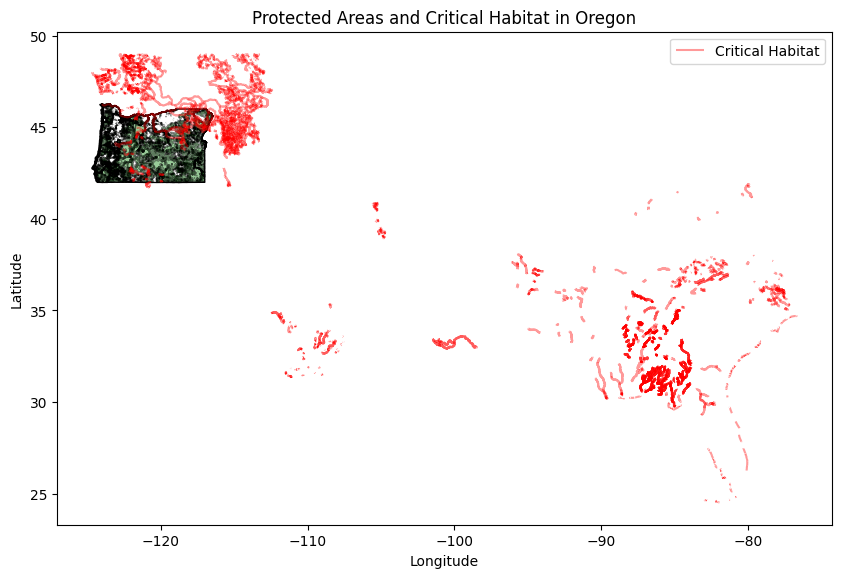

In [14]:
# Create a base map of Oregon state boundaries
fig, ax = plt.subplots(figsize=(10, 10))
state_bounds.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot Protected Areas in red
protected_areas_corrected.plot(ax=ax, color='green', edgecolor='black', alpha=0.4, label='Protected Areas')

# Plot Critical Habitat in blue
critical_habitat.plot(ax=ax, color='red', edgecolor='black', alpha=0.4, label='Critical Habitat')

# Add legend and title
plt.legend()
plt.title("Protected Areas and Critical Habitat in Oregon")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Oops. It seems our critical habitat data is global, and must be clipped. We can either choose to zoom in on the graph, or use our state bounds function to clip the data to fit the state of Oregon. For analysis purposes, we will use the clip route today

In [15]:
crit_hab_clip = gpd.clip(critical_habitat, state_bounds)
#prot_areas_clip = gpd.clip(protected_areas_corrected, state_bounds)

<ipython-input-16-3c23e3ba0a5b>:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


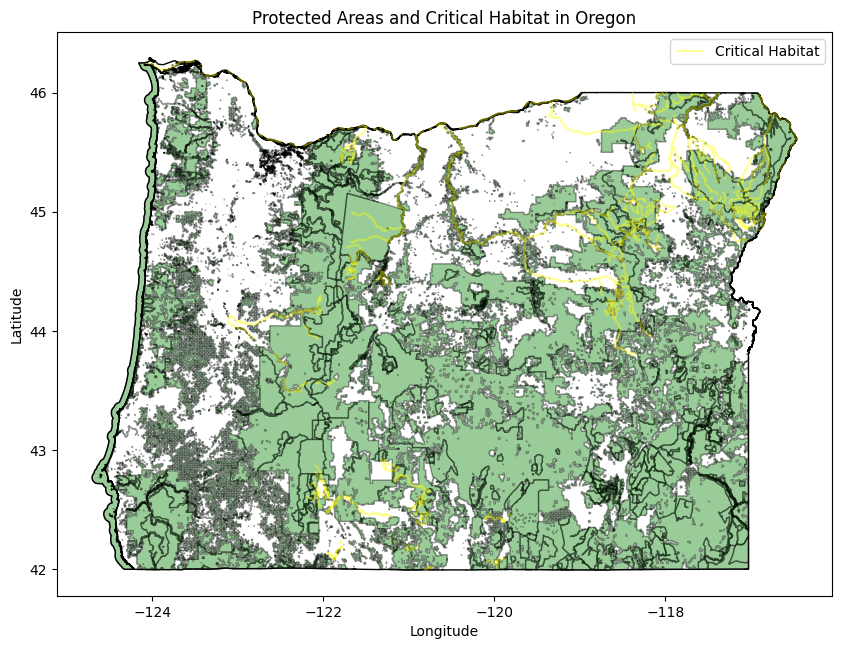

In [16]:
# Create a base map of Oregon state boundaries
fig, ax = plt.subplots(figsize=(10, 10))
state_bounds.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot Protected Areas in red
protected_areas_corrected.plot(ax=ax, color='green', edgecolor='black', alpha=0.4, label='Protected Areas')

# Plot Critical Habitat in yellow
crit_hab_clip.plot(ax=ax, color='yellow', edgecolor='black', alpha=0.4, label='Critical Habitat')

# Add legend and title
plt.legend()
plt.title("Protected Areas and Critical Habitat in Oregon")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


We have a plot! As you can see, Oregon has a large area of protected areas. The red lines represent critical habitat general area, and we will use the line intersections with protected area polygons as a proxy to answer our question.

# Calculating Overlap
Now we will vizually identify the overlap that exists between protected areas and critical habitat in Oregon, and begin our analyses. Using an 'gpd.sjoin' function, we will be able to quantify the amount of overlap that exists between the two habitat classifications.

In [17]:
# Calculate intersection
intersection  = gpd.sjoin(protected_areas_corrected, crit_hab_clip, predicate='intersects')

What is this intersection variable now? Take a second to look at the rows.

In [20]:
#Determining the amount of polygons have intersections with the multiline objects
len(intersection)

137

In [ ]:
#Observing the number of rows in our protected areas column
len(protected_areas_corrected)

1613

In [ ]:
#Simple calculation to determine the proportion of protected areas that contain critcal habitat
len(intersection)/len(protected_areas_corrected) * 100

8.493490390576564

# Discussion Questions


*   What data would make this analysis better?
*   What findings might warrant action?
*   What are the limitations of the data?


*   Given the limitations of our dataset, what can we take away from this anlysis?





# Thank You!
I hope this tutorial gave you a better idea of how plots and python functions can be used to answer real world conservation problems.